In [1]:
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [2]:
!pwd

/content


In [3]:
!ls

sample_data


**GET DATASET READY**

In [4]:
#!wget https://github.com/joolsa/fake_real_news_dataset/raw/master/fake_or_real_news.csv.zip

--2020-01-16 08:33:17--  https://github.com/joolsa/fake_real_news_dataset/raw/master/fake_or_real_news.csv.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/joolsa/fake_real_news_dataset/master/fake_or_real_news.csv.zip [following]
--2020-01-16 08:33:22--  https://raw.githubusercontent.com/joolsa/fake_real_news_dataset/master/fake_or_real_news.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11878108 (11M) [application/zip]
Saving to: ‘fake_or_real_news.csv.zip’

fake_or_real_news.c 100%[===================>]  11.33M  --.-KB/s    in 0.1s    

2020-01-16 08:33:23 (85.3 MB/s) - ‘fake_or_real_n

In [5]:
#!unzip fake_or_real_news.csv

Archive:  fake_or_real_news.csv.zip
  inflating: fake_or_real_news.csv   
   creating: __MACOSX/
  inflating: __MACOSX/._fake_or_real_news.csv  


In [6]:
!ls

fake_or_real_news.csv  fake_or_real_news.csv.zip  __MACOSX  sample_data


In [34]:
df = pd.read_csv("fake_or_real_news.csv", error_bad_lines=False)
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
Unnamed: 0    6335 non-null int64
title         6335 non-null object
text          6335 non-null object
label         6335 non-null object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [0]:
x = df['title'] + " " + df['text']
y = pd.get_dummies(df['label'])
y = np.array(y)

In [37]:
x[0]

'You Can Smell Hillary’s Fear Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. \nIn the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI. \nThe word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI. \nBut that’s exactly what Hillary and her people have done. Coma patients just waking up now and watching an hour of CNN from their hospital beds would assume that FBI Director James Comey is Hillary’s opponent in this election. \nThe FBI is under attack by everyone from Obama to CNN. Hillary’s people have circulated a letter attacking Comey. There are currently more media hit pieces lambasting him than targeting Trump. It wouldn’t be too surprising if the Clintons or their allies were to start running attack ads against the FBI. \nThe FBI’s leadership i

In [38]:
y

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [0, 1],
       [0, 1]], dtype=uint8)

In [0]:
y=pd.get_dummies(df['label'])


In [43]:
y.head()

,FAKE,REAL
0,1,0
1,1,0
2,0,1
3,1,0
4,0,1


**DEFINING MODEL & INPUT PARAMETERS**

In [0]:
MAX_NB_WORDS = 100000 # max number of words for tokenizer
MAX_SEQUENCE_LENGTH = 1000 # max length of each sentences, including padding
VALIDATION_SPLIT = 0.2 # 20% of data for validation (not used in training)
EMBEDDING_DIM = 100 # embedding dimensions for word vectors
GLOVE_DIR = "glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

**DATA CLEANING**

In [0]:
def clean_text(text, remove_stopwords = True):
 output = ""
 text = str(text).replace(r'http[\w:/\.]+','') # removing urls
 text = str(text).replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
 text = str(text).replace(r'\.\.+','.') #replace multiple periods with a single one
 text = str(text).replace(r'\.',' . ') #replace periods with a single one
 text = str(text).replace(r'\s\s+',' ') #replace multiple white space with a single one
 text = str(text).replace("\n", "") #removing line breaks
 text = re.sub(r'[^\w\s]','',text).lower() #lower texts
 output=list(output)
 if remove_stopwords:
  text = text.split(" ")
  for word in text:
   if word not in stopwords.words("english"):
     output = output + list(" ") +list(word)
   else:
     output = text
 #output=str(output)
 return str(str(output).strip())[1:-3].replace(" ", " ")

**remove_stopwords works by download the stopwords package from nltk.**

In [16]:
import nltk
nltk.download('stopwords')
texts = [] 
for line in tqdm_notebook(x, total=df.shape[0]): 
 texts.append(clean_text(line))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [45]:
texts[0]
y=np.array(y)
y[0]
print('Sample data:', texts[0],y[0])

Sample data: 'you', 'can', 'smell', 'hillarys', 'fear', 'daniel', 'greenfield', 'a', 'shillman', 'journalism', 'fellow', 'at', 'the', 'freedom', 'center', 'is', 'a', 'new', 'york', 'writer', 'focusing', 'on', 'radical', 'islam', 'in', 'the', 'final', 'stretch', 'of', 'the', 'election', 'hillary', 'rodham', 'clinton', 'has', 'gone', 'to', 'war', 'with', 'the', 'fbi', 'the', 'word', 'unprecedented', 'has', 'been', 'thrown', 'around', 'so', 'often', 'this', 'election', 'that', 'it', 'ought', 'to', 'be', 'retired', 'but', 'its', 'still', 'unprecedented', 'for', 'the', 'nominee', 'of', 'a', 'major', 'political', 'party', 'to', 'go', 'war', 'with', 'the', 'fbi', 'but', 'thats', 'exactly', 'what', 'hillary', 'and', 'her', 'people', 'have', 'done', 'coma', 'patients', 'just', 'waking', 'up', 'now', 'and', 'watching', 'an', 'hour', 'of', 'cnn', 'from', 'their', 'hospital', 'beds', 'would', 'assume', 'that', 'fbi', 'director', 'james', 'comey', 'is', 'hillarys', 'opponent', 'in', 'this', 'electi

**TOKENISATION**

In [21]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 142469


**PADDING**

In [46]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (6335, 1000)
Shape of label tensor: (6335, 2)


**SHUFFLE DATA**

In [0]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

**SPLIT DATA**

In [49]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [2528 2540]
validation:  [636 631]


In [50]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [ 1514   739  3141  4640  4001 13081  3956  1514   739  3141  4640  4001
 13081  3956  1514   739  3141  4640  4001 13081  3956    20   501  3253
  1514   739   136     1 23949  1514  1783    11  1669   291     6     1
  1271  1105  1953  3956    57 14519     1   567     3   242     6     1
 51457   719     3 16550  6200   102   587  1271  1105  1214     8  4640
     4 22335    31  1792     1   489 11774    81  9381     4   274  4857
   210     1   654     7   242    18  2417    81 13081    20  1226  6757
   505    64   327  7879   882    10    20  8148   695    43     1   311
  3100     1   805   567     3 51458 12901 33197 42191     4 51459    34
  2227  1514     2   535     9    40 23858    31   212     6    32   719
    68   497    13  1271  1105  1953   122   242    65  2227  1514   176
 29600     4 37716   264   123  1527 51458 12901    34    54     2    19
   523    28    49  1138    13     5  1051   906     2  2151    29    55
   726     2  1783     4  54

**DOWNLOAD GLOVE DATASET**

In [56]:
!pwd
#!mkdir glove
#!wget -o /content/glove/glove.6b.zip http://nlp.stanford.edu/data/glove.6B.zip


/content


In [59]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


**PERFORM WORD EMBEDDINGS**

In [67]:
embeddings_index = {}
GLOVE_DIR = "glove.6B."+str(EMBEDDING_DIM)+"d.txt"
f = open(GLOVE_DIR, encoding='utf8')
print('Loading Glove from:', GLOVE_DIR,'…', end='')
for line in f:
 values = line.split()
 word = values[0]
 embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix…", end="")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
print(embedding_matrix)
for word, i in word_index.items():
 embedding_vector = embeddings_index.get(word)
 if embedding_vector is not None:
   #embedding_matrix[i] = embedding_vector
   print(embedding_vector)
print("Completed!")


Loading Glove from: glove.6B.100d.txt …Done.
 Proceeding with Embedding Matrix…[[0.2469652  0.90041188 0.89711589 ... 0.35152238 0.66443113 0.52184417]
 [0.46732093 0.16302207 0.35115721 ... 0.07748404 0.37994464 0.62613186]
 [0.32425522 0.7422632  0.37084126 ... 0.69113828 0.25375292 0.95153006]
 ...
 [0.9293541  0.53560673 0.58989924 ... 0.13080085 0.2003644  0.8179169 ]
 [0.71662117 0.67610243 0.96388012 ... 0.74256751 0.51609792 0.19807173]
 [0.89799352 0.26743829 0.81635486 ... 0.99897428 0.75990499 0.01557742]]
[ 0.16478   0.17071   0.62111  -1.2101   -0.84063   0.21893   0.48123
 -0.15044   0.36701  -0.20857  -0.23385   0.019356 -0.045098  0.18001
  0.11995  -0.25622  -0.026299  0.28473  -0.91322   0.59811   0.30248
  0.27973   0.11444  -0.073628  0.88137   1.0633   -0.22116  -0.7982
 -0.137    -0.2935    0.30011  -0.027594  0.13646   0.0495    0.066336
  0.62306   0.4118    0.090881  0.20817  -1.1378   -0.15726  -0.27827
 -0.16412   0.50816  -0.75323  -0.33559  -0.14433  -0.853

**MODEL INITIALIZATION**

In [68]:
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(Embedding(len(word_index) + 1,
 EMBEDDING_DIM,
 weights = [embedding_matrix],
 input_length = MAX_SEQUENCE_LENGTH,
 trainable=False,
 name = 'embeddings'))
model.add(LSTM(60, return_sequences=True,name='lstm_layer'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(2, activation="sigmoid"))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


**TRAIN MODEL**

In [69]:
model.compile(optimizer='adam', loss='binary_crossentropy',
 metrics = ['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [70]:
history = model.fit(x_train, y_train, epochs = 10, batch_size=128, validation_data=(x_val, y_val))

Train on 5068 samples, validate on 1267 samples
Epoch 1/10
5068/5068 [==============================] - 83s 16ms/sample - loss: 0.6969 - acc: 0.4976 - val_loss: 0.6935 - val_acc: 0.4882
Epoch 2/10
5068/5068 [==============================] - 82s 16ms/sample - loss: 0.6937 - acc: 0.5027 - val_loss: 0.6944 - val_acc: 0.5016
Epoch 3/10
5068/5068 [==============================] - 82s 16ms/sample - loss: 0.6937 - acc: 0.5018 - val_loss: 0.6934 - val_acc: 0.5110
Epoch 4/10
5068/5068 [==============================] - 82s 16ms/sample - loss: 0.6942 - acc: 0.4904 - val_loss: 0.6936 - val_acc: 0.4842
Epoch 5/10
5068/5068 [==============================] - 82s 16ms/sample - loss: 0.6928 - acc: 0.5116 - val_loss: 0.6938 - val_acc: 0.4921
Epoch 6/10
5068/5068 [==============================] - 82s 16ms/sample - loss: 0.6925 - acc: 0.5169 - val_loss: 0.6939 - val_acc: 0.4878
Epoch 7/10
5068/5068 [==============================] - 82s 16ms/sample - loss: 0.6922 - acc: 0.5185 - val_loss: 0.6943 - va

**EVALUATE MODEL**

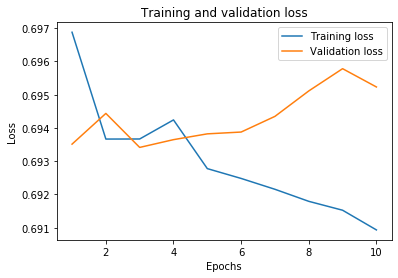

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

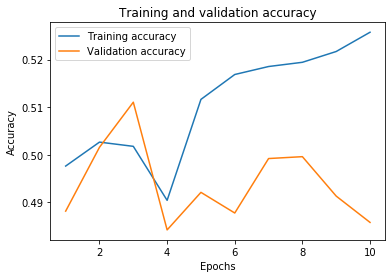

In [72]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [0]:
random_num = np.random.randint(0, 100)
test_data = x[random_num]
test_label = y[random_num]
clean_test_data = clean_text(test_data)
test_tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
test_tokenizer.fit_on_texts(clean_test_data)
test_sequences = tokenizer.texts_to_sequences(clean_test_data)
word_index = test_tokenizer.word_index
test_data_padded = pad_sequences(test_sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [0]:
prediction = model.predict(test_data_padded)

In [75]:
prediction[random_num].argsort()[-len(prediction[random_num]):]

array([0, 1])

**RESULT PREVIEW**

In [76]:
test_data

'Lavrov and Kerry discuss Syrian settlement Lavrov and Kerry discuss Syrian settlement October 28, 2016 TASS \nRussian Foreign Ministry Sergey Lavrov and U.S. Secretary of State John Kerry discussed the Syrian settlement as well as the situation in Yemen and Libya by telephone on Oct. 28. \nThe Russian Foreign Ministry said that the conversation had taken place at the U.S. side’s request. \n"The foreign policy chiefs continued discussing ways of settling the Syrian conflict, including the normalization of the situation around Aleppo, with account taken of fundamental approaches contained in the previously reached Russian-U.S. agreements. For that, the United States should ultimately separate moderate opposition (in Syria) from terror groups," the Russian Foreign Ministry said. \n"Lavrov and Kerry also discussed assistance to the solution of crises in Yemen and Libya as well as separate issues of bilateral agenda," the Russian Foreign Ministry stressed.'

**Final Inference**

We see the  LSTM model on a fake news dataset does Predicted above text and got an accuracy of 91%. 